## Natural Language Autocomplete

In this notebook, we"re going to use transformers to get semantic suggestions for a given term.

In [1]:
import sys
sys.path.append("../..")
from aips import *
from aips.spark import create_view_from_collection
import pandas
import pickle
import json
import tqdm
import spacy
import numpy
from spacy.matcher import Matcher
from IPython.display import display,HTML
from aips import get_engine
from pyspark.sql import SparkSession
import sentence_transformers

engine = get_engine()
pandas.set_option("display.max_rows", 1000)
spark = SparkSession.builder.appName("AIPS").getOrCreate()

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load and clean the Outdoors dataset

In [2]:
create_view_from_collection(engine.get_collection("outdoors"), "outdoors")
outdoors_dataframe = spark.sql("SELECT * from outdoors")
print(outdoors_dataframe.count())

18456


## Make a vocabulary of all the concepts in a corpus

In [3]:
nlp = spacy.load("en_core_web_sm")

## Listing 13.9

In [4]:
def normalize(span):
    return " ".join([token.lemma_.lower() for token in span])

def yield_tuple(dataframe, column, total):
    total = total or 100
    for idx, row in dataframe.iterrows():
        if idx < total:
            yield (row[column], idx)

def get_concepts(collection, source_field, total=None, load_from_cache=True):
    if load_from_cache:
        os.makedirs(os.path.dirname("data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
        with open("data/outdoors/outdoors_concepts.pickle","rb") as fd:
            concepts = pickle.load(fd)
        with open("data/outdoors/outdoors_labels.pickle","rb") as fd:
            labels = pickle.load(fd)
        return concepts,labels

    #Setting load_from_cache to False will bring you here
    print("Extracting concepts. This could take a while. Take a break and stretch :)")
    create_view_from_collection(collection, "concept_data")
    dataframe = spark.sql("SELECT * FROM concept_data")
        
    #Get all the noun and verb phrases in the content
    phrases = [] #All the normalized noun/verb phrases ("concepts") in the corpus
    sources = [] #The original text labels that was normalized to the concept
    
    #Use the spacy matcher to chunk patterns into concept labels
    #We don't need a full taxonomy graph extraction, just a vocabulary with term frequencies
    matcher = Matcher(nlp.vocab)
    nountags = ["NN", "NNP", "NNS", "NOUN"] #Nouns
    verbtags = ["VB", "VBD", "VBG", "VBN",
                "VBP", "VBZ", "VERB"] #Verbs
    matcher.add("noun_phrases", [[{"TAG": {"IN": nountags},
                                   "IS_ALPHA": True,
                                   "OP": "+"}]])
    matcher.add("verb_phrases", [[{"TAG": {"IN": verbtags},
                                   "IS_ALPHA": True, "OP": "+",
                                   "LEMMA": {"NOT_IN": ["be"]}}]])
    for doc, _ in tqdm.tqdm(nlp.pipe(yield_tuple(dataframe,
                                                 source_field,
                                                 total),
                                     batch_size=40,
                                     n_threads=4,
                                     as_tuples=True),
                             total=total):
        matches = matcher(doc)
        for _, start, end in matches:
            span = doc[start:end]
            phrases.append(normalize(span))
            sources.append(span.text)            
    
    #Aggregate the normalized concepts by term frequency
    concepts = {}
    labels = {}
    for i, phrase in phrases:
        if phrase not in concepts:
            concepts[phrase] = 0
            labels[phrase] = sources[i]
        concepts[phrase] += 1
    
    sorted_concepts = {k: v for k, v in sorted(concepts.items(), key=lambda item: item[1], reverse=True)}
    
    os.makedirs(os.path.dirname("data/outdoors/outdoors_concepts.pickle"), exist_ok=True)
    with open("data/outdoors/outdoors_concepts.pickle","wb") as fd:
        pickle.dump(sorted_concepts, fd)
    with open("data/outdoors/outdoors_labels.pickle","wb") as fd:
        pickle.dump(labels, fd)
    
    return sorted_concepts, labels

## Listing 13.10

### Examining the vocabulary

What are the concepts with the highest frequency?

In [5]:
collection = engine.get_collection("outdoors")
concepts, labels = get_concepts(collection, source_field="body",
                                load_from_cache=True)
topcons = {key: value for (key, value)
           in concepts.items() if value > 5}
print(f"Total number of labels: {len(labels.keys())}")
print(f"Total number of concepts: {len(concepts.keys())}")
print(f"Concepts with greater than 5 term frequency: {len(topcons.keys())}")
print(json.dumps(topcons, indent=2))

Total number of labels: 124366
Total number of concepts: 124366
Concepts with greater than 5 term frequency: 12375
{
  "have": 32782,
  "do": 26869,
  "use": 16793,
  "get": 13412,
  "go": 9899,
  "water": 9537,
  "make": 9476,
  "need": 7814,
  "time": 7187,
  "take": 6550,
  "find": 6359,
  "see": 5591,
  "rope": 5540,
  "know": 5522,
  "day": 5318,
  "way": 5239,
  "want": 5087,
  "people": 5083,
  "keep": 4789,
  "look": 4784,
  "area": 4548,
  "work": 4491,
  "thing": 4451,
  "try": 4179,
  "tent": 4095,
  "bag": 4054,
  "lot": 3934,
  "think": 3728,
  "trail": 3725,
  "say": 3669,
  "foot": 3606,
  "climb": 3559,
  "point": 3550,
  "place": 3539,
  "question": 3424,
  "help": 3206,
  "come": 3186,
  "put": 3115,
  "hike": 3042,
  "weight": 3034,
  "fall": 3027,
  "start": 3009,
  "leave": 2977,
  "answer": 2949,
  "give": 2945,
  "something": 2926,
  "food": 2907,
  "year": 2864,
  "carry": 2823,
  "pack": 2755,
  "end": 2752,
  "one": 2741,
  "bear": 2738,
  "fire": 2730,
  "bod

## Transformer time!

In [6]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

## Listing 13.11

In [7]:
def get_embeddings(texts, model, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = model.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [8]:
#Note!  This is a hyperparameter.
#We are ignoring terms that occur less than this numner in the entire corpus.
#Lowering this number may lower precision
#Raising this number may lower recall
minimum_frequency = 6
phrases = [key for (key, tf) in concepts.items() if tf >= minimum_frequency]
cache_name = "outdoors_embeddings"
#set ignore_cache=True to regenerate the embeddings rather than loading from the cache
embeddings = get_embeddings(phrases, transformer, cache_name, ignore_cache=False)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

Number of embeddings: 12375
Dimensions per embedding: 768


## Listing 13.12

### Explore the top similarities for the top terms

In [9]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [10]:
def rank_similarities(phrases, similarities):
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(similarities) - 1):
        for b in range(a + 1, len(similarities)):
            a_phrases.append(phrases[a])
            b_phrases.append(phrases[b])
            scores.append(float(similarities[a][b]))
    dataframe = pandas.DataFrame({"score": scores,
                                  "phrase a": a_phrases, "phrase b": b_phrases})
    dataframe["idx"] = range(len(dataframe))
    dataframe = dataframe.reindex(columns=["idx", "score", "phrase a", "phrase b"])
    return dataframe.sort_values(by=["score"], ascending=False,
                                    ignore_index=True)

In [11]:
#Find the pairs with the highest cosine similarity scores
normalized_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence_transformers.util.dot_score(
    normalized_embeddings[0:250],
    normalized_embeddings[0:250])
comparisons = rank_similarities(phrases, similarities)
display(HTML(comparisons[:10].to_html(index=False)))

idx,score,phrase a,phrase b
31096,0.928151,protect,protection
13241,0.923570,climbing,climber
18096,0.878894,camp,camping
7282,0.833662,climb,climbing
10312,0.821081,something,someone
8813,0.815187,hike,hiking
4182,0.784663,people,person
7354,0.782961,climb,climber
1027,0.770643,go,leave
4422,0.768611,keep,stay


## Listing 13.13

/opt/conda/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Using repr(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


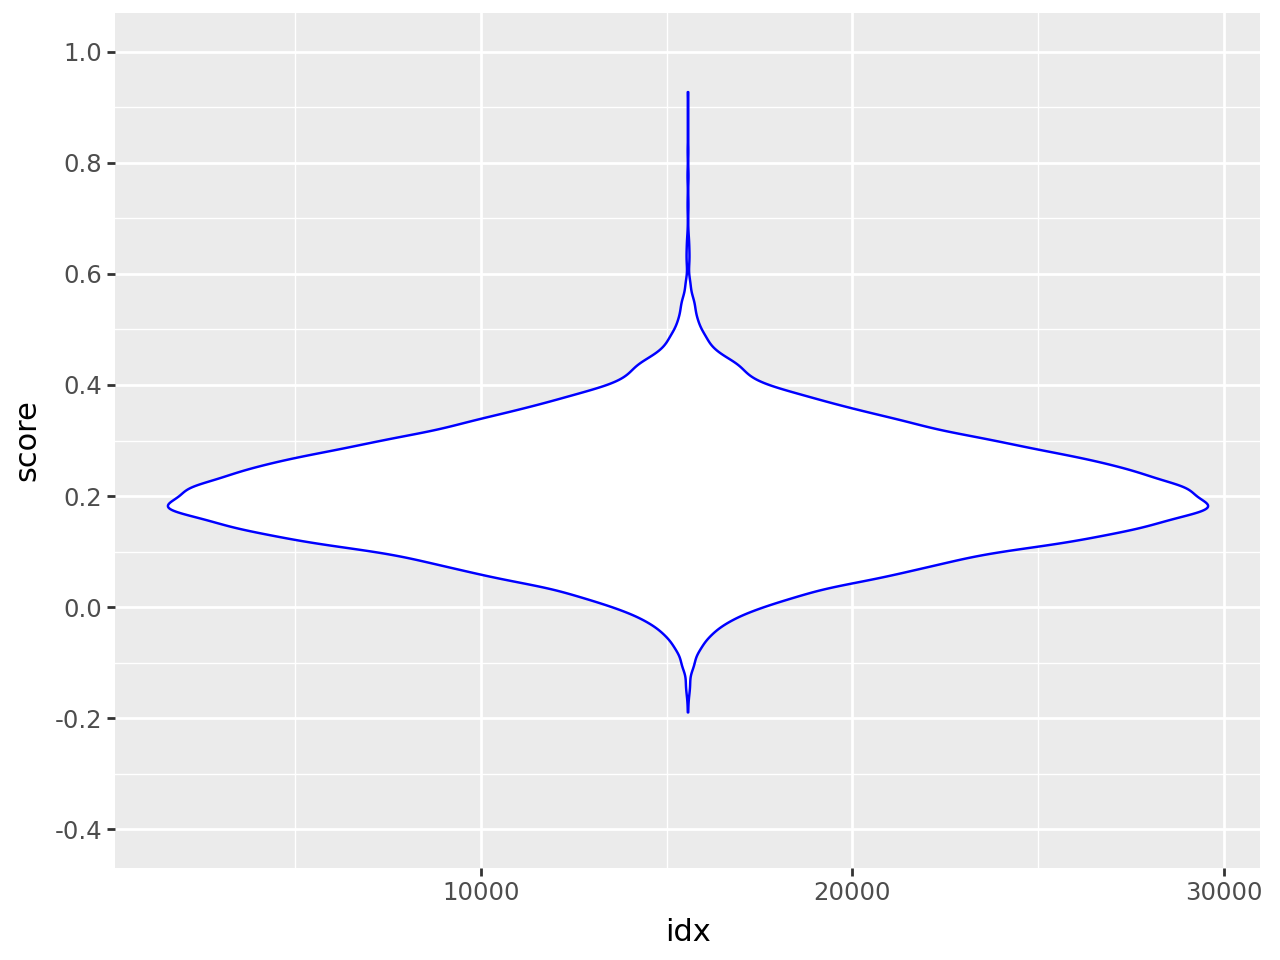

{<Figure Size: (640 x 480)>}

In [12]:
from plotnine import *
candidate_synonyms = comparisons[comparisons["score"] > 0.0]
{
    ggplot(comparisons, aes("idx", "score")) + 
    geom_violin(color="blue") +
    scale_y_continuous(limits=[-0.4, 1.0],
                       breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.14

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [13]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
concepts_index = nmslib.init(method="hnsw",
                             space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
concepts_index.addDataPointBatch(normalized_embeddings)
concepts_index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term "bag"
ids, _ = concepts_index.knnQuery(
    normalized_embeddings[25], k=10)
matches = [labels[phrases[i]].lower() for i in ids]
display(matches)

['bag',
 'bag ratings',
 'bag cover',
 'bag liner',
 'garbage bags',
 'wag bags',
 'bag cooking',
 'airbag',
 'paper bag',
 'tea bags']

## Listing 13.15

In [14]:
def print_labels(prefix,matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for (l, d) in matches:
        print(str(int(d * 1000) / 1000), "|", l)

In [15]:
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        similarity = distances[i] * -1
        if similarity >= min_similarity:
            matches.append((phrases[ids[i]], similarity))
    if not len(matches):
        matches.append((phrases[ids[1]], distances[1] * -1))
    return matches

def semantic_suggest(prefix, phrases):
    matches = embedding_search(concepts_index, prefix, phrases)
    print_labels(prefix, matches)

In [16]:
semantic_suggest("mountain hike", phrases)

1.0 | mountain hike
0.975 | mountain hiking
0.847 | mountain trail
0.787 | mountain guide
0.779 | mountain terrain
0.775 | mountain climbing
0.768 | mountain ridge
0.754 | winter hike


In [17]:
semantic_suggest("campfire", phrases)

0.999 | campfire
0.956 | camp fire
0.928 | campfire impact
0.865 | camping fuel
0.823 | camping stove
0.796 | camp stove
0.775 | cooking fire
0.774 | campground
0.764 | fireplace
0.759 | camping area
0.755 | have camp


In [18]:
semantic_suggest("dehyd", phrases)

0.941 | dehydrate
0.931 | dehydration
0.852 | rehydration
0.851 | dehydrator
0.836 | hydration
0.835 | hydrating
0.822 | rehydrate
0.812 | hydrate
0.788 | hydration pack
0.776 | hydration system


In [19]:
semantic_suggest("compa", phrases)

0.863 | comp
0.829 | compact
0.803 | compile
0.792 | compost
0.786 | compass
0.778 | competitor
0.765 | competence
0.758 | compactor
0.755 | compare


## Addendum: Bias Excercise
These cells enable exploration for detecting similarity/context bias that may exist in a model

In [20]:
def build_candidate_set(cons):
    terms = list(cons.keys())
    originals = []
    candidates = []
    scores = []
    for term in tqdm.tqdm(terms[0:1000]):
        labels = embedding_search(concepts_index, term, phrases=terms, k=25)
        originals += [term] * len(labels)
        candidates += [l[0] for l in labels]
        scores += [l[1] for l in labels]
    pairs = pandas.DataFrame({"term": originals, "candidate": candidates, "score":scores})
    return pairs

In [21]:
pairs = build_candidate_set(topcons)
pairs.to_csv("pairs.csv")

100%|██████████| 1000/1000 [00:17<00:00, 56.27it/s]


In [22]:
#Compare a list of terms
def compare(terms):

    term_embeddings = transformer.encode(terms, convert_to_tensor=True)
    
    a_phrases = []
    b_phrases = []
    scores = []
    for a in range(len(terms) - 1):
        for b in range(a + 1, len(terms)):
            a_phrases.append(terms[a])
            b_phrases.append(terms[b])
            sim = sentence_transformers.util.pytorch_cos_sim(
                term_embeddings[a], term_embeddings[b])
            scores.append(float(sim))

    comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                    "score": scores, "name": "similarity"})
    comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
    return comparisons

In [23]:
#Gender-occupational bias example
#Note the similarity scores for gender and occupation 
compare(["man", "woman", "nurse practitioner", "doctor"])

,phrase a,phrase b,score,name
0,nurse practitioner,doctor,0.488934,similarity
1,man,woman,0.280403,similarity
2,woman,nurse practitioner,0.179482,similarity
3,man,doctor,0.084211,similarity
4,woman,doctor,0.028788,similarity
5,man,nurse practitioner,-0.030063,similarity


## Addendum: Vector Space Visualization Figure 13.6
This cell uses Principal Component Analysis (PCA) to reduce embeddings to 3 dimensions so they can be plotted in 3d.

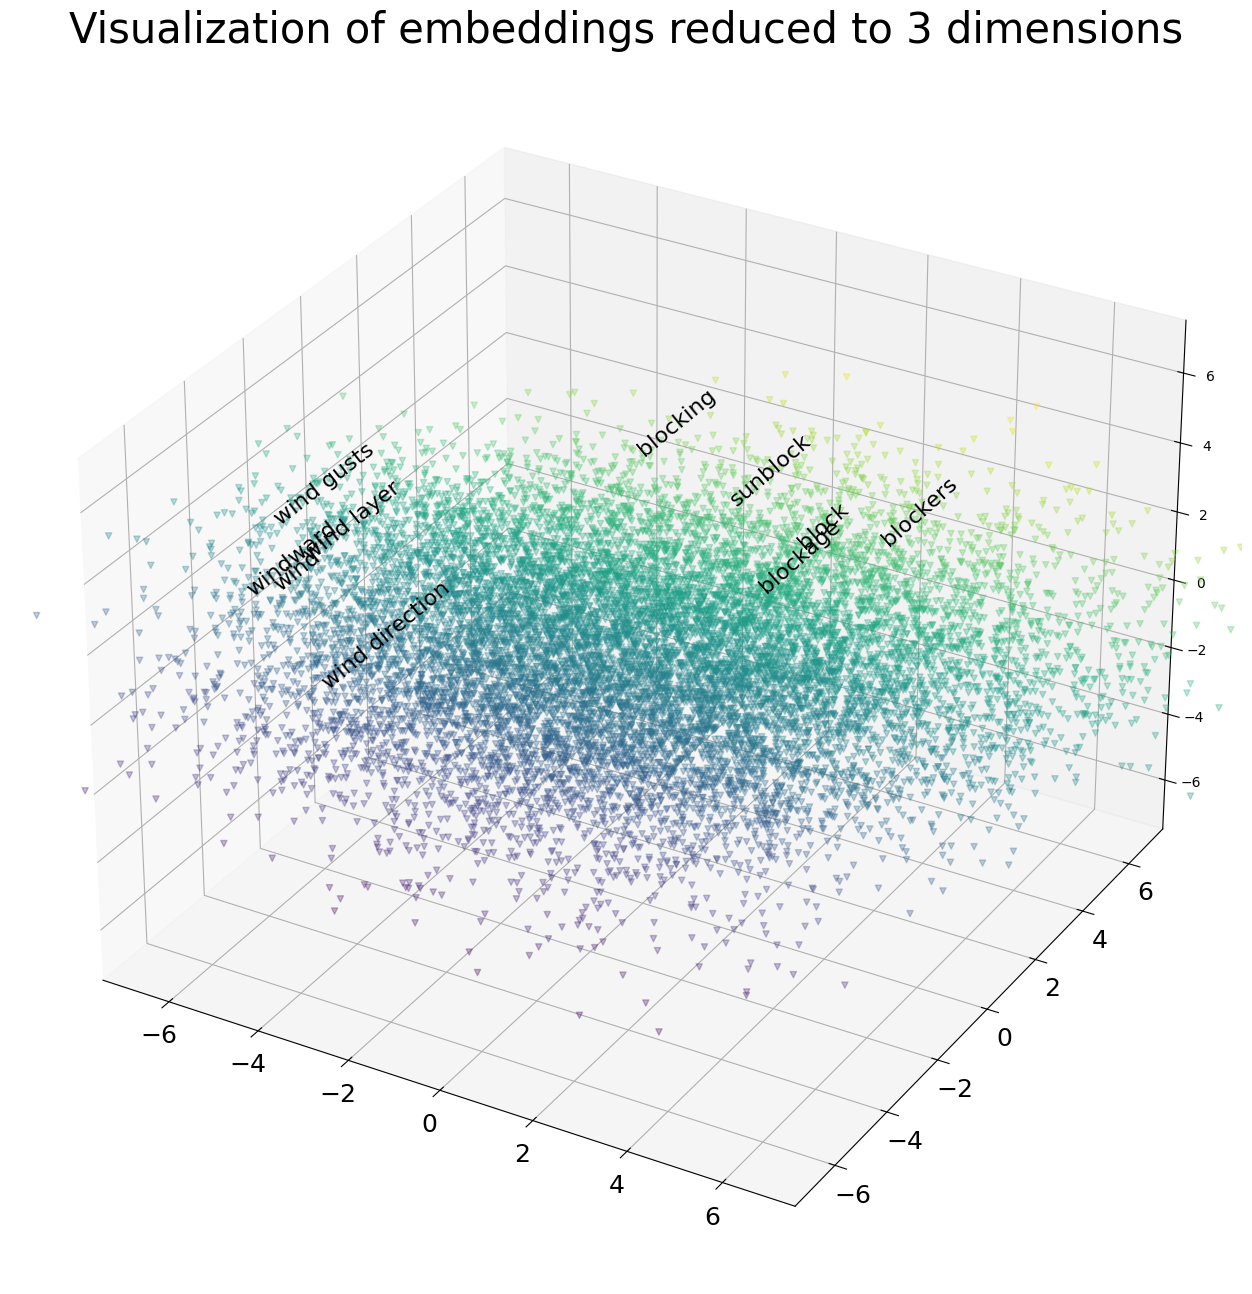

In [24]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = numpy.array(embeddings)
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = concepts_index.knnQuery(embeddings[100], k=5)
label_ids += [idx for idx in ids]
ids,_ = concepts_index.knnQuery(embeddings[505], k=5)
label_ids += [idx for idx in ids]
label_texts += [labels[phrases[idx]].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir, fontsize=16)

ax.set_xlim(-7.5, 7.5)
ax.set_ylim(-7.5, 7.5)
ax.set_zlim(-7.5, 7.5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
ax.set_title('Visualization of embeddings reduced to 3 dimensions', fontsize=30) # increase or decrease y as needed
plt.show()

## Addendum: Find topic vector centroids with KMeans

In [25]:
from torch import stack as  torch_stack
from sklearn.cluster import KMeans

def semanticnearest(embeddings,k=20):
    matches = []
    ids, distances = concepts_index.knnQuery(embeddings, k=k)
    for i in range(len(ids)):
        text = phrases[ids[i]]
        dist = distances[i] * -1
        if dist>0.6:
            matches.append((ids[i], text, dist))
    if not len(matches):
        matches.append(([ids[1]], phrases[ids[1]], dist))
    return matches

In [26]:
def findcentroids(embeddings, n_clusters=8, max_iter=300):
    centroids = []
    centroid_embeddings = []
    vectors = numpy.array(embeddings)
    kmeans = KMeans(n_clusters=n_clusters, random_state=505, max_iter=max_iter).fit(vectors)
    for centroid in kmeans.cluster_centers_:
        matches = semanticnearest(centroid,k=5)
        centroids.append(matches[0])
        centroid_embeddings.append(embeddings[matches[0][0]])
        display(HTML(f"<h4>Results for: <em> centroid {str(len(centroids)-1)}</em></h4>"))
        for i,l,d in matches:
            if l in labels.keys():
                l = labels[l].lower()
            print(str(i) + "\t" + l + "\t" + str(d))
    
    return centroids,torch_stack(centroid_embeddings)

In [ ]:
centroids, centroid_embeddings = findcentroids(embeddings, n_clusters=100,  max_iter=50)

In [ ]:
print(centroids)
print(centroid_embeddings)

[(10466, 'handwash', 0.8039088249206543), (150, 'backpack', 0.789563775062561), (80, 'ice', 0.8592484593391418), (11915, 'canvas tarp', 0.722813606262207), (1880, 'in', 0.7571237087249756), (6103, 'sw', 0.8860063552856445), (1852, 'd', 0.8285518884658813), (2602, 'n', 0.8527299761772156), (8521, 'plateaus', 0.756929874420166), (6062, 'weather change', 0.8357369899749756), (4103, 'insight', 0.8352082371711731), (3763, 'ass', 0.7401955127716064), (8926, 'have teach', 0.7313310503959656), (12166, 'wren', 0.8052818775177002), (10456, 'nice', 0.8788074851036072), (7202, 'moisture content', 0.8020135164260864), (9900, 'pipistrelle', 0.8525463342666626), (7229, 'base weight', 0.7779852747917175), (9957, 'water boat', 0.8313672542572021), (4020, 'daytime', 0.8735556602478027), (4866, 'discontinue', 0.8149714469909668), (9994, 'cavern', 0.7767986059188843), (6603, 'retirement', 0.8234813213348389), (1538, 'spine', 0.8231596946716309), (8227, 'strangle', 0.7923411726951599), (18, 'keep', 0.85979

In [ ]:
normalized_centroid_embeddings = list(map(normalize_embedding, embeddings))
similarities = sentence.dot_score(normalized_centroid_embeddings, normalized_centroid_embeddings)
print("The shape of the resulting similarities:", similarities.shape)

The shape of the resulting similarities: torch.Size([100, 100])


### KMeans Topic distribution

This cell below shows good distribution of similarity scores for our topics.

In [ ]:
import pandas

a_phrases = []
b_phrases = []
scores = []

for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(centroids[a][1])
        b_phrases.append(centroids[b][1])
        scores.append(float(similarities[a][b]))

df = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases, "score":scores})
df.sort_values(by=["score"], ascending=False, ignore_index=True)

,phrase a,phrase b,score
0,revise,increment,0.723681
1,wren,wy,0.713014
2,b,bacon,0.671149
3,temperature,heat,0.666397
4,start,new,0.664019
...,...,...,...
4945,sw,monoxide,-0.149354
4946,camping area,t,-0.173272
4947,camping area,oxygen bottle,-0.177567
4948,start,have sleep,-0.190825


Up next: [Semantic Search with Dense Vector Embeddings](4.semantic-search.ipynb)